# iCAT import
---

### Conventions

#### Nomenclature
`stack`
`layer`
`tileset`

#### Heirarchy
`stack` | `z` | `section`

#### [TileSpec](https://github.com/fcollman/render-python/blob/master/renderapi/tilespec.py#L17) parameters

| Field    | Type     | Default | Description                                |
| -----    | ----     | ------- | -----------                                |
| tileId   | str      | None    | Unique string specifying a tile's identity |
| z        | float    | None    | z values this tile exists within           |
| width    | int      | None    | Width in pixels of the raw tile            |
| height   | int      | None    | Height in pixels of the raw tile           |
| imageUrl | str      | None    | An image path URI                          |
| maskUrl  | str      | None    | An image path for an alpha mask            |
| minint   | int      | 0       | Pixel intensity value to display as black  |
| maxint   | int      | 65535   | Pixel intensity value to display as white  |
| layout   | `Layout` | None    | a `Layout` object for this tile            |
| tforms   | list     | [ ]     | Transform objects                          |

#### [Layout](https://github.com/fcollman/render-python/blob/master/renderapi/layout.py#L1) parameters

| Field     | Type  | Default | Description                                  |
| -----     | ----  | ------- | -----------                                  |
| sectionId | str   | None    | sectionId this tile was taken from           |
| scopeId   | str   | None    | What microscope this came from               |
| cameraId  | str   | None    | Camera this was taken with                   |
| imageRow  | int   | None    | Row from a row,col layout this was taken     |
| imageCol  | int   | None    | Column from a row,col layout this was taken  |
| stageX    | float | None    | X stage coordinates for where this was taken |
| stageY    | float | None    | Y stage coordinates for where this was taken |
| rotation  | float | None    | Angle of camera when this was taken          |
| pixelsize | float | None    | Effective size of pixels                     |

So the game plan will be to build up layouts and tile specifications from metadata and apriori knowledge we have our of our image data. Then we will import the tile specifications into `render-ws` using the appropriate `render-python` method.

In [232]:
from pathlib import Path
from itertools import product
from pprint import pprint

from tqdm import tqdm_notebook
from bs4 import BeautifulSoup as Soup
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.ticker as mticker

from skimage.external.tifffile import TiffFile, imread
from skimage.exposure import histogram

import renderapi
from renderapi.tilespec import TileSpec
from renderapi.layout import Layout
from renderapi.transform import AffineModel as AffineRender

from icatapi.importo import parse_metadata

## Set up environment
---

In [250]:
# `render` project parameters
# ---------------------------
owner = 'rlane'  # replace with your name
project = '20191230_RL010'

# Data directories
# ----------------
project_dir = Path(f'/long_term_storage/{owner}/SECOM/projects/20191101_RL010')
stack_dirs = list(project_dir.glob('[!_]*/[!_]*'))

# Additional parameters
# ---------------------
section_thickness = 100  # nm

# Infer section and stack names
# -----------------------------
sections = np.unique([fp.parent.name for fp in stack_dirs]).tolist()
stacks = np.unique([fp.name for fp in stack_dirs]).tolist()
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]

out = f"""\
sections..... {sections}
all stacks... {stacks}
EM stacks.... {stacks_EM}
FM stacks.... {stacks_FM}
"""
print(out)

sections..... ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009']
all stacks... ['big_EM', 'hoechst', 'insulin', 'lil_EM']
EM stacks.... ['big_EM', 'lil_EM']
FM stacks.... ['hoechst', 'insulin']



### Create `render-ws` instance

In [251]:
# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
pprint(render.make_kwargs())

{'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'host': 'http://sonic',
 'memGB': '2G',
 'owner': 'rlane',
 'port': 8080,
 'project': '20191230_RL010'}


## Build up image tile DataFrame
---

In [14]:
# Initialize DataFrame
tile_dicts = []

# Iterate through stack directories
for fp_stack in tqdm_notebook(stack_dirs):

    # Set stack and section
    stack = fp_stack.name
    section = fp_stack.parent.name

    # Iterate through tile data
    fps_tiles = list(fp_stack.glob('*.tif'))
    for i, fp_tile in enumerate(fps_tiles):

        # Parse metadata
        tile_dict = parse_metadata(fp_tile, section)
        tile_dict['stack'] = stack
        tile_dict['section'] = section
        tile_dicts.append(tile_dict)

# Build DataFrame
df_tiles = pd.DataFrame(tile_dicts)
# Preview
cols_preview = ['z', 'section', 'imageRow', 'imageCol',
                'stageX', 'stageY', 'width', 'height',
                'pixelsize', 'tileId', 'acqTime']
df_tiles.groupby(['stack'])\
        .apply(lambda x: x.sample(3))[cols_preview]

z section  imageRow  imageCol       stageX       stageY  width  \
stack                                                                          
big_EM  1093  4    S004         1         0   830.656000  6371.012000   4096   
        1100  4    S004         0         2  1211.580000  6565.542000   4096   
        740   3    S003         0         1   416.041000  6535.337000   4096   
hoechst 358   2    S002         2         0  -361.221398  6120.696586   2048   
        2857  9    S009         2         2  4213.045879  6166.919407   2048   
        713   3    S003         1         0   229.148156  6340.945910   2048   
insulin 23    1    S001         3         2  -570.443158  5905.827960   2048   
        2148  7    S007         1         0  2641.440178  6381.014980   2048   
        727   3    S003         3         0   229.834946  5951.200950   2048   
lil_EM  305   1    S001         9        13  -581.136000  6224.806000   4096   
        2908  9    S009         5         1  3975.811000  6318.003000   4096   
        2841  8    S008        14        15  3641.245000  6179.843000   4096   

              height   pixelsize                    tileId             acqTime  
stack                                                                           
big_EM  1093    4096   33.566317   big_EM-S004-00000x00001 2019-11-02 15:50:28  
        1100    4096   33.566317   big_EM-S004-00002x00000 2019-11-02 15:44:58  
        740     4096   33.566317   big_EM-S003-00001x00000 2019-11-02 15:03:00  
hoechst 358     2048  106.372739  hoechst-S002-00000x00002 2019-11-02 14:41:34  
        2857    2048  106.541082  hoechst-S009-00002x00002 2019-11-02 18:40:27  
        713     2048  106.398678  hoechst-S003-00000x00001 2019-11-02 15:10:12  
insulin 23      2048  106.321854  insulin-S001-00002x00003 2019-11-02 14:00:47  
        2148    2048  106.477481  insulin-S007-00000x00001 2019-11-02 17:38:04  
        727     2048  106.386818  insulin-S003-00000x00003 2019-11-02 15:21:16  
lil_EM  305     4096    4.859737   lil_EM-S001-00013x00009 2019-11-02 22:23:00  
        2908    4096    4.859506   lil_EM-S009-00001x00005 2019-11-05 19:02:10  
        2841    4096    4.859506   lil_EM-S008-00015x00014 2019-11-05 15:17:42

### Image tile count

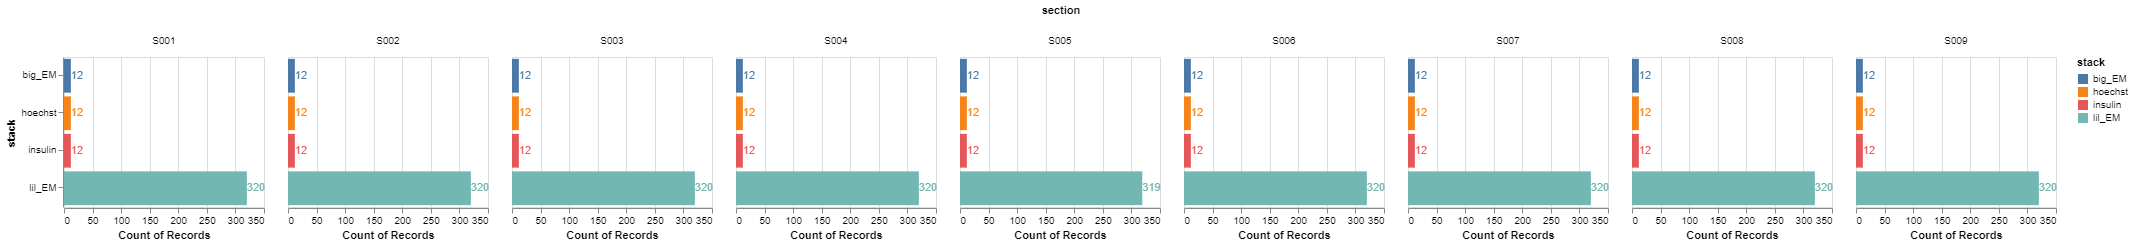

In [15]:
# Make tile count DataFrame for plotting / display purposes
df_tilecount = df_tiles.loc[:, ['section', 'stack', 'z']]
bars = alt.Chart(df_tilecount).mark_bar().encode(
    x='count()',
    y='stack:N',
    color='stack:N',
)

text = bars.mark_text(
    align='left',
    baseline='middle'
).encode(
    text='count()'
)

alt.layer(bars, text, data=df_tilecount).properties(
    width=200,
    height=150,
).facet(
    column='section:N'
)

## Refine image tile DataFrame
---

### `tileId` - add alphanumeric prefix

In [16]:
def gen_prefix(n=3):
    """Generates a sequence of length `n` characters in alphabetical order
    e.g. for n=3 [aaa, aab, aac, ..., zzx, zzy, zzz]
    """
    n = min(n, 4)
    characters = 'abcdefghijklmnopqrstuvwxyz'
    for s in product(characters, repeat=n):
        yield ''.join(s)

In [17]:
# Group by tileset
tilesets = []
for (stack, z), tileset in df_tiles.groupby(['stack', 'z']):
    
    # Sort by acquisition time such that top entry is last acquired
    tileset = tileset.sort_values('acqTime', ascending=False)\
                     .reset_index(drop=True).copy()
    
    # Prepend alphanumeric prefix to each tileId
    prefixes = pd.Series(gen_prefix())[:len(tileset)]
    tileset['tileId'] = prefixes + '_' + tileset['tileId']
    tilesets.append(tileset)
    
# Update image tile DataFrame
df_tiles = pd.concat(tilesets).reset_index(drop=True)
# Preview
df_tiles.groupby(['stack'])\
        .apply(lambda x: x.head(3))[cols_preview]

z section  imageRow  imageCol      stageX       stageY  width  \
stack                                                                        
big_EM  0    1    S001         3         0 -954.430000  5906.398000   4096   
        1    1    S001         3         1 -763.989000  5906.401000   4096   
        2    1    S001         3         2 -573.547000  5906.478000   4096   
hoechst 108  1    S001         3         0 -951.984544  5905.630277   2048   
        109  1    S001         3         1 -761.187101  5905.677940   2048   
        110  1    S001         3         2 -570.443158  5905.827960   2048   
insulin 216  1    S001         3         0 -951.984544  5905.630277   2048   
        217  1    S001         3         1 -761.187101  5905.677940   2048   
        218  1    S001         3         2 -570.443158  5905.827960   2048   
lil_EM  324  1    S001        19         0 -809.153000  6049.631000   4096   
        325  1    S001        19         1 -791.563000  6049.626000   4096   
        326  1    S001        19         2 -774.143000  6049.629000   4096   

             height   pixelsize                        tileId  \
stack                                                           
big_EM  0      4096   33.566317   aaa_big_EM-S001-00000x00003   
        1      4096   33.566317   aab_big_EM-S001-00001x00003   
        2      4096   33.566317   aac_big_EM-S001-00002x00003   
hoechst 108    2048  106.356298  aaa_hoechst-S001-00000x00003   
        109    2048  106.337112  aab_hoechst-S001-00001x00003   
        110    2048  106.321854  aac_hoechst-S001-00002x00003   
insulin 216    2048  106.356298  aaa_insulin-S001-00000x00003   
        217    2048  106.337112  aab_insulin-S001-00001x00003   
        218    2048  106.321854  aac_insulin-S001-00002x00003   
lil_EM  324    4096    4.859737   aaa_lil_EM-S001-00000x00019   
        325    4096    4.859737   aab_lil_EM-S001-00001x00019   
        326    4096    4.859737   aac_lil_EM-S001-00002x00019   

                        acqTime  
stack                            
big_EM  0   2019-11-02 14:04:30  
        1   2019-11-02 14:02:40  
        2   2019-11-02 14:00:51  
hoechst 108 2019-11-02 14:04:22  
        109 2019-11-02 14:02:33  
        110 2019-11-02 14:00:43  
insulin 216 2019-11-02 14:04:26  
        217 2019-11-02 14:02:37  
        218 2019-11-02 14:00:47  
lil_EM  324 2019-11-03 01:43:53  
        325 2019-11-03 01:42:44  
        326 2019-11-03 01:41:34

### Stage coordinates

### `tforms` - set affine transformations

### `minint`, `maxint` - set min, max intensity levels 

#### FM channels
Sample `N` FM image tiles (per section), take histogram and assign min, max intensity levels according to min and max percentile specified

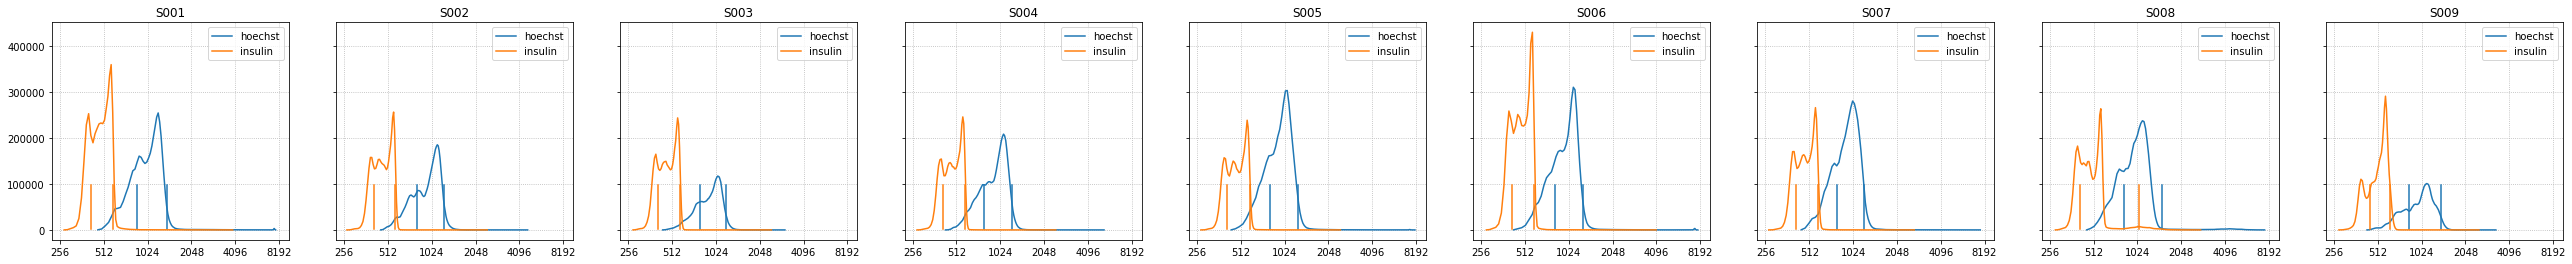

In [223]:
# Parameters
# ----------
N = 10     # Sample size
pct1 = 20  # min %ile
pct2 = 95  # max %ile

# Set up figure
ncols=len(sections)
fig, axes = plt.subplots(ncols=ncols, sharex=True, sharey=True,
                         figsize=(ncols*5, 4))

# Loop through FM stacks
total = len(stacks_FM) * len(sections)
axes_map = {k: v for k, v in zip(sections, axes.flat)}
cmap = {k: v for k, v in zip(stacks_FM, sns.color_palette(n_colors=len(stacks_FM)))}
for i, ((stack, section), tileset) in tqdm_notebook(enumerate(df_tiles.loc[df_tiles['stack'].isin(stacks_FM)]\
                                                                      .groupby(['stack', 'section'])), total=total):
    # Choose random sample
    fps = tileset.sample(n=min(N, len(tileset)))['imageUrl']

    # Loop through sample image tiles
    images = []
    for fp in fps:

        # Accumulate images
        image = imread(fp.split('://')[1])
        images.append(image)

    # Take histograms
    mean = np.mean(images, axis=0)
    hist, bin_centers = histogram(mean)
    p1, p2 = np.percentile(mean, (pct1, pct2))

    # Set min, max intensity
    df_tiles.loc[(df_tiles['stack'] == stack) &\
                 (df_tiles['section'] == section),
                 ['minint', 'maxint']] = int(p1), int(p2)

    # Plot
    ax = axes_map[section]
    color = cmap[stack]
    ax.plot(bin_centers, hist, color=color, label=stack)
    [ax.axvline(p, ymin=0.05, ymax=0.25, color=color) for p in [p1, p2]]
    # Aesthetics
    ax.set_title(section)
    ax.set_xscale('symlog', basex=2)
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.legend()
    ax.grid(ls=':')

#### EM channels
Sample `N` FM image tiles (per section), take histogram and assign min, max intensity levels according to min and max percentile specified

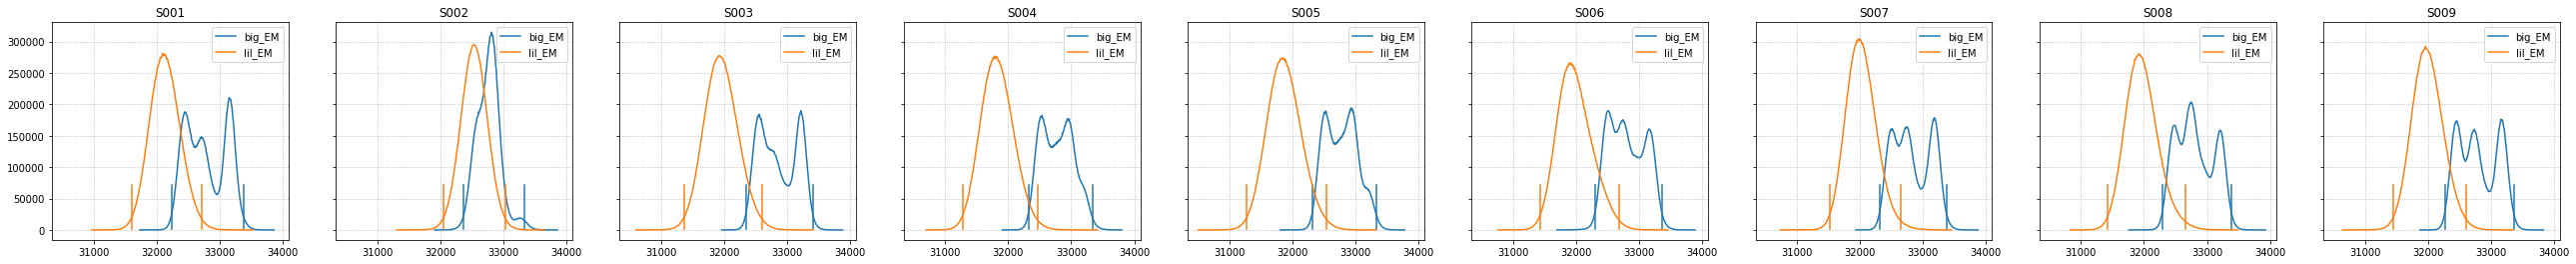

In [226]:
# Parameters
# ----------
N = 10     # Sample size
pct1 = 1   # min %ile
pct2 = 99  # max %ile

# Set up figure
ncols=len(sections)
fig, axes = plt.subplots(ncols=ncols, sharex=True, sharey=True,
                         figsize=(ncols*5, 4))

# Loop through EM stacks
total = len(stacks_EM) * len(sections)
axes_map = {k: v for k, v in zip(sections, axes.flat)}
cmap = {k: v for k, v in zip(stacks_EM, sns.color_palette(n_colors=len(stacks_EM)))}
for i, ((stack, section), tileset) in tqdm_notebook(enumerate(df_tiles.loc[df_tiles['stack'].isin(stacks_EM)]\
                                                                      .groupby(['stack', 'section'])), total=total):
    # Choose random sample
    fps = tileset.sample(n=min(N, len(tileset)))['imageUrl']

    # Loop through sample image tiles
    images = []
    for fp in fps:

        # Accumulate images
        image = imread(fp.split('://')[1])
        images.append(image)

    # Take histograms
    mean = np.mean(images, axis=0)
    hist, bin_centers = histogram(mean)
    p1, p2 = np.percentile(mean, (pct1, pct2))

    # Set min, max intensity
    df_tiles.loc[(df_tiles['stack'] == stack) &\
                 (df_tiles['section'] == section),
                 ['minint', 'maxint']] = int(p1), int(p2)

    # Plot
    ax = axes_map[section]
    color = cmap[stack]
    ax.plot(bin_centers, hist, color=color, label=stack)
    [ax.axvline(p, ymin=0.05, ymax=0.25, color=color) for p in [p1, p2]]
    # Aesthetics
    ax.set_title(section)
    ax.legend()
    ax.grid(ls=':')

#### Optionally overwrite min, max intensity levels

In [216]:
# # Specify stack and section(s)
# stack_ = 'insulin'
# sections_ = ['S002', 'S003', 'S005']

# df_tiles.loc[(df_tiles['stack'] == stack_) &\
#              (df_tiles['section'].isin(sections_)),
#              ['minint', 'maxint']] = 0, 65535

In [217]:
# Preview
df_tiles.groupby('stack')\
        .apply(lambda x: x.sample(3))[cols_preview + ['minint', 'maxint']]

z section  imageRow  imageCol       stageX       stageY  width  \
stack                                                                          
big_EM  15    2    S002         2         2    16.428000  6120.927000   4096   
        23    2    S002         0         0  -364.426000  6510.063000   4096   
        16    2    S002         2         1  -174.005000  6120.914000   4096   
hoechst 138   3    S003         1         0   229.148156  6340.945910   2048   
        136   3    S003         2         1   420.167882  6146.126249   2048   
        187   7    S007         1         1  2832.009499  6381.316683   2048   
insulin 309   8    S008         0         2  3637.263123  6577.241090   2048   
        292   7    S007         2         1  2832.251922  6186.423544   2048   
        279   6    S006         2         2  2418.660329  6186.761886   2048   
lil_EM  1330  4    S004        17        14  1219.387000  6142.948000   4096   
        2469  7    S007         5         2  2804.843000  6347.775000   4096   
        2958  9    S009        15        11  4151.002000  6143.086000   4096   

              height   pixelsize                        tileId  \
stack                                                            
big_EM  15      4096   33.566317   aad_big_EM-S002-00002x00002   
        23      4096   33.566317   aal_big_EM-S002-00000x00000   
        16      4096   33.566317   aae_big_EM-S002-00001x00002   
hoechst 138     2048  106.398678  aag_hoechst-S003-00000x00001   
        136     2048  106.387415  aae_hoechst-S003-00001x00002   
        187     2048  106.467145  aah_hoechst-S007-00001x00001   
insulin 309     2048  106.532374  aaj_insulin-S008-00002x00000   
        292     2048  106.446226  aae_insulin-S007-00001x00002   
        279     2048  106.439378  aad_insulin-S006-00002x00002   
lil_EM  1330    4096    4.859506   abu_lil_EM-S004-00014x00017   
        2469    4096    4.859506   ais_lil_EM-S007-00002x00005   
        2958    4096    4.859506   acx_lil_EM-S009-00011x00015   

                         acqTime   minint   maxint  
stack                                               
big_EM  15   2019-11-02 14:45:21  32594.0  33347.0  
        23   2019-11-02 14:30:43  32594.0  33347.0  
        16   2019-11-02 14:43:31  32594.0  33347.0  
hoechst 138  2019-11-02 15:10:12    772.0   1197.0  
        136  2019-11-02 15:13:52    772.0   1197.0  
        187  2019-11-02 17:36:11    797.0   1234.0  
insulin 309  2019-11-02 18:00:57    416.0   1059.0  
        292  2019-11-02 17:41:43    415.0    588.0  
        279  2019-11-02 17:01:01    418.0    594.0  
lil_EM  1330 2019-11-04 03:03:39  31868.0  32525.0  
        2469 2019-11-04 23:43:02  31807.0  32388.0  
        2958 2019-11-05 21:56:27  31766.0  32393.0

## Import image tiles to `render-ws`
---

### Create stacks

In [246]:
# Iterate through stacks
for stack, df_stack in tqdm_notebook(df_tiles.groupby('stack')):

    # Create `TileSpec`s
    tile_specs = []
    for i, tile in df_stack.iterrows():
        ts = TileSpec(**tile.to_dict())
        tile_specs.append(ts)

    # Set stack resolution
    Rx = df_stack['pixelsize'].iloc[0]
    Ry = df_stack['pixelsize'].iloc[0]
    Rz = section_thickness

    # Create stack
    renderapi.stack.create_stack(stack,
                                 stackResolutionX=Rx,
                                 stackResolutionY=Ry,
                                 stackResolutionZ=Rz,
                                 render=render)

    # Import TileSpecs to render
    renderapi.client.import_tilespecs(stack,
                                      tile_specs,
                                      render=render)

    # Set stack state to complete
    renderapi.stack.set_stack_state(stack, 'COMPLETE', render=render)